# Rossmann Store Sales Prediction

In [1]:
import pandas as pd
from pandas import Series,DataFrame

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
import datetime
import random

from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

/home/ubuntu/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### 读取数据原文件

In [2]:
rossmann_df  = pd.read_csv("data/train.csv")
store_df     = pd.read_csv("data/store.csv")
test_df      = pd.read_csv("data/test.csv")

#train_df = pd.merge(rossmann_df, store_df, how='left', on='Store')
#test_df = pd.merge(test_df, store_df, how='left', on='Store')

display(rossmann_df.head()),display(test_df.head()),display(store_df.head())
#rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


(None, None, None)

In [3]:
rossmann_df.info()
print("==========================")
test_df.info()
print("==========================")
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ 

### 规范数据：StateHoliday 

In [4]:
dict_train = {}
dict_test = {}
for col in ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday']:
    #print("=====",col,"=====")
    #print('train:',rossmann_df[col].unique())
    #print('test:',test_df[col].unique())
    dict_train[col] = rossmann_df[col].unique()
    dict_test[col] = test_df[col].unique()
    
pd.DataFrame(data=[dict_train,dict_test],index=['train','test'])

,DayOfWeek,Open,Promo,SchoolHoliday,StateHoliday
train,"[5, 4, 3, 2, 1, 7, 6]","[1, 0]","[1, 0]","[1, 0]","[0, a, b, c, 0]"
test,"[4, 3, 2, 1, 7, 6, 5]","[1.0, nan, 0.0]","[1, 0]","[0, 1]","[0, a]"


In [5]:
rossmann_df["StateHoliday"].loc[rossmann_df["StateHoliday"] == 0] = "0"
rossmann_df["StateHoliday"].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

### 变量观察

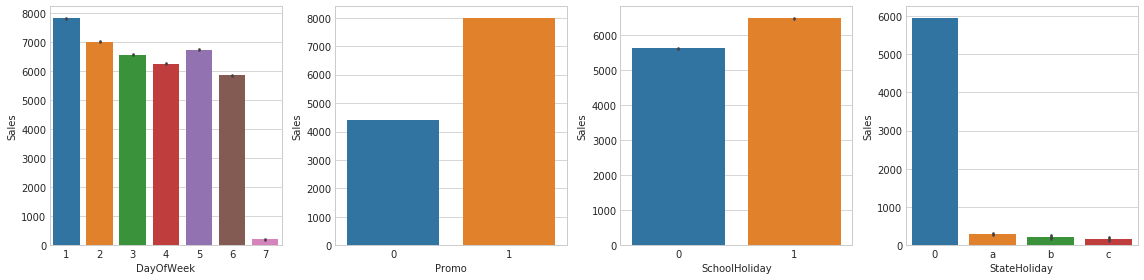

In [6]:
fig,ax=plt.subplots(1,4,figsize=(16,4))
ax=plt.subplot(141)
sns.barplot(data=rossmann_df,x='DayOfWeek',y='Sales')
ax=plt.subplot(142)
sns.barplot(data=rossmann_df,x='Promo',y='Sales')
ax=plt.subplot(143)
sns.barplot(data=rossmann_df,x='SchoolHoliday',y='Sales')
ax=plt.subplot(144)
sns.barplot(data=rossmann_df,x='StateHoliday',y='Sales')
plt.tight_layout()

### 规范数据：测试集 Open 缺失

In [7]:
test_df[test_df['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


#### 缺失数据全部为622号店铺，周一至周六（没有周日）

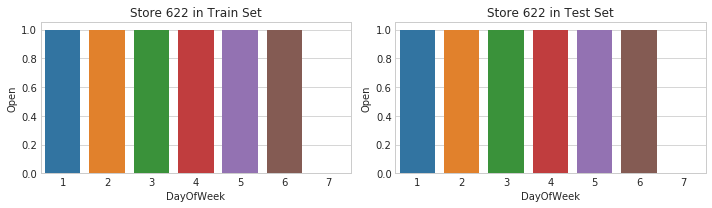

In [8]:
fig,ax=plt.subplots(1,2,figsize=(10,3))
ax=plt.subplot(121)
sns.barplot(data=rossmann_df[(rossmann_df['Store']==622)&(rossmann_df['StateHoliday']=='0')],x='DayOfWeek',y='Open')
ax.set_title('Store 622 in Train Set')
ax=plt.subplot(122)
sns.barplot(data=test_df[test_df['Store']==622],x='DayOfWeek',y='Open')
ax.set_title('Store 622 in Test Set')
plt.tight_layout()

#### 由统计可得：622店铺在所有周一至周六全开业，而周日休息，故此处的缺失值补1（开业）

In [9]:
test_df['Open']=test_df['Open'].fillna(1)
test_df.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854361,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352748,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


### 合并训练、测试集，以便后续统一做变换处理以及时间维度分析

In [10]:
rossmann_df['SalesLog'] = np.log1p(rossmann_df['Sales'])
rossmann_df['Set'] = [1]*len(rossmann_df)
test_df['Set'] = [2]*len(test_df)

all_df = pd.concat([rossmann_df,test_df])
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 12 columns):
Customers        1017209 non-null float64
Date             1058297 non-null object
DayOfWeek        1058297 non-null int64
Id               41088 non-null float64
Open             1058297 non-null float64
Promo            1058297 non-null int64
Sales            1017209 non-null float64
SalesLog         1017209 non-null float64
SchoolHoliday    1058297 non-null int64
Set              1058297 non-null int64
StateHoliday     1058297 non-null object
Store            1058297 non-null int64
dtypes: float64(5), int64(5), object(2)
memory usage: 105.0+ MB


#### 销售额标签，做log变换后，更趋近于正态分布

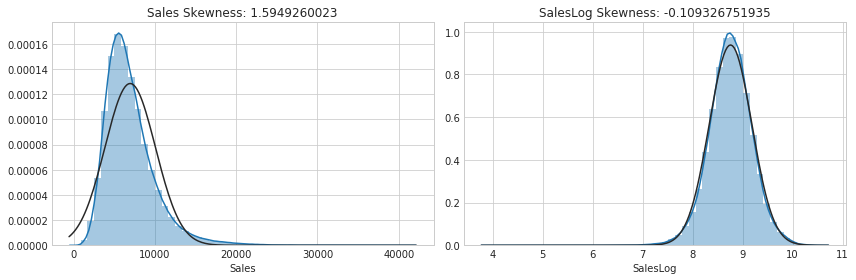

In [11]:
# 计算偏度，转换后偏度绝对值减小，更贴近正态分布
s2 = rossmann_df[['Sales','SalesLog']].apply(lambda x: skew(x[x>0])).sort_values(ascending=False)

fig,ax=plt.subplots(1,2,figsize=(12,4))
ax=plt.subplot(121)
sns.distplot(rossmann_df[rossmann_df['Sales']>0]['Sales'],fit=norm)
title1 = 'Sales Skewness: '+str(s2['Sales'])
ax.set_title(title1)
ax=plt.subplot(122)
sns.distplot(rossmann_df[rossmann_df['Sales']>0]['SalesLog'],fit=norm)
title2 = 'SalesLog Skewness: '+str(s2['SalesLog'])
ax.set_title(title2)
plt.tight_layout()

### 时间维度分解衍生变量

In [12]:
def dataset_date_derivation(df,col='Date'):
    print("[DEBUG] Preprocessing: Date..")
    df[col] = pd.to_datetime(df[col])
    df['Year'] = df.Date.dt.year
    df['MonthofYear'] = df.Date.dt.month
    df['WeekofYear'] = df.Date.dt.weekofyear
    df['DayofMonth'] = df.Date.dt.day
    df['DayofYear'] = df.Date.dt.dayofyear
    df['DateInt'] = df['Date'].astype(np.int64)
    return df

all_df = dataset_date_derivation(all_df)
all_df.info()

[DEBUG] Preprocessing: Date..
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 18 columns):
Customers        1017209 non-null float64
Date             1058297 non-null datetime64[ns]
DayOfWeek        1058297 non-null int64
Id               41088 non-null float64
Open             1058297 non-null float64
Promo            1058297 non-null int64
Sales            1017209 non-null float64
SalesLog         1017209 non-null float64
SchoolHoliday    1058297 non-null int64
Set              1058297 non-null int64
StateHoliday     1058297 non-null object
Store            1058297 non-null int64
Year             1058297 non-null int64
MonthofYear      1058297 non-null int64
WeekofYear       1058297 non-null int64
DayofMonth       1058297 non-null int64
DayofYear        1058297 non-null int64
DateInt          1058297 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(11), object(1)
memory usage: 153.4+ MB


-----
### 观察在各节日的开业店铺数，可见在很多日期，部分店铺并不认为是节日，且各店铺的开业状态不一致，因此后续在时间维度上的更多衍生变量，比如对节日的相对天数，需要按店铺单独计算。

(-150, 1200)

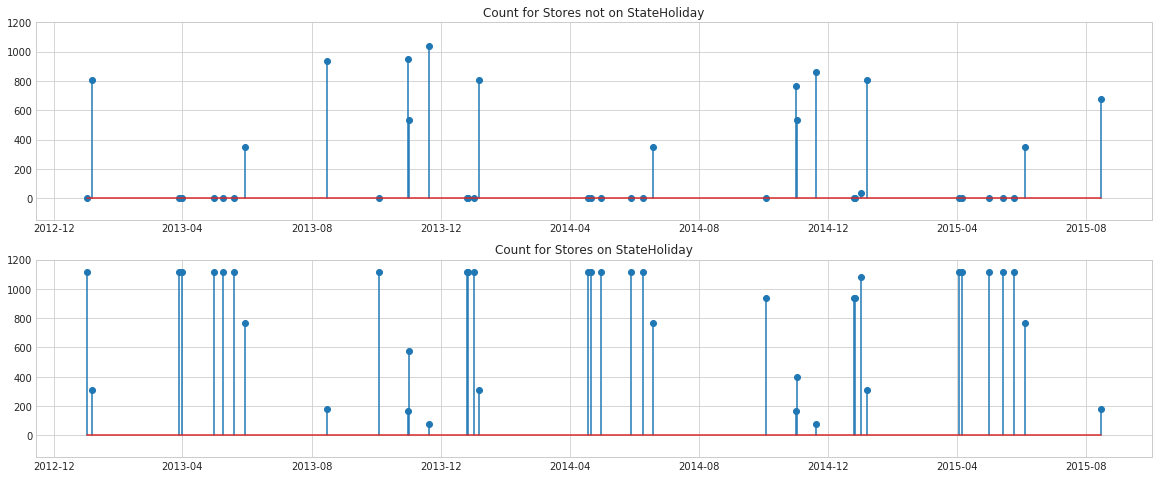

In [13]:
tmp_list0 = [[{'Date':dt},
              all_df[all_df['Date']==dt]['StateHoliday'].value_counts().to_dict()
             ] 
             for dt in all_df[all_df['StateHoliday']!='0']['Date'].unique()
            ]
tmp_list = [dict(**tmp[0],**tmp[1]) for tmp in tmp_list0]
tmp_df = pd.DataFrame(tmp_list).fillna(0)
tmp_df['onHoliday'] = tmp_df[['a','b','c']].apply(lambda x: np.sum(x), axis=1)
#display(tmp_df)

fig,ax1=plt.subplots(2,1,figsize=(20,8))
ax=plt.subplot(211)
plt.stem(tmp_df['Date'],tmp_df['0'])
ax.set_title('Count for Stores not on StateHoliday')
plt.ylim([-150,1200])
ax=plt.subplot(212)
plt.stem(tmp_df['Date'],tmp_df['onHoliday'])
ax.set_title('Count for Stores on StateHoliday')
plt.ylim([-150,1200])
#plt.tight_layout()

(-150, 1200)

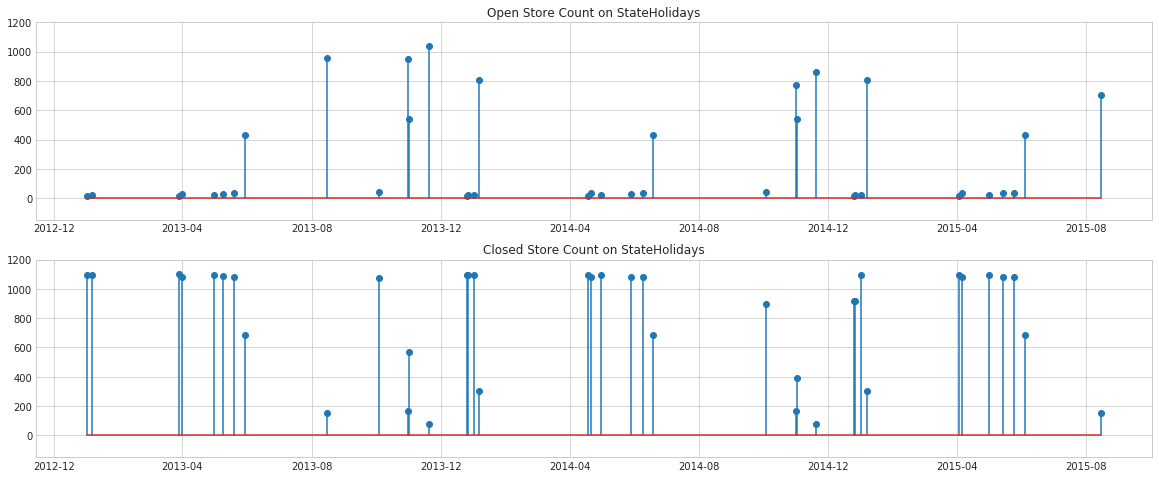

In [14]:
tmp_list0 = [[dt,all_df[all_df['Date']==dt]['Open'].value_counts()] for dt in all_df[all_df['StateHoliday']!='0']['Date'].unique()]
tmp_list = [{'Date':tmp[0],'Open':tmp[1][1],'Closed':tmp[1][0]} for tmp in tmp_list0]
tmp_df = pd.DataFrame(tmp_list)

fig,ax1=plt.subplots(2,1,figsize=(20,8))
ax=plt.subplot(211)
plt.stem(tmp_df['Date'],tmp_df['Open'])
ax.set_title('Open Store Count on StateHolidays')
plt.ylim([-150,1200])
ax=plt.subplot(212)
plt.stem(tmp_df['Date'],tmp_df['Closed'])
ax.set_title('Closed Store Count on StateHolidays')
plt.ylim([-150,1200])
#plt.tight_layout()

### 基于不同店铺的销量表现很大程度上可能不相关，此处剔除测试集没有的店铺及其数据

In [15]:
def drop_stores(df, stores):
    for store in stores:
        df = df[df.Store != store]
    return df

train_stores = all_df['Store'].unique().tolist()
test_stores = test_df['Store'].unique().tolist()
tobe_removed = list(set(train_stores).difference(set(test_stores)))
all_df = drop_stores(all_df, tobe_removed)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814319 entries, 0 to 41087
Data columns (total 18 columns):
Customers        773231 non-null float64
Date             814319 non-null datetime64[ns]
DayOfWeek        814319 non-null int64
Id               41088 non-null float64
Open             814319 non-null float64
Promo            814319 non-null int64
Sales            773231 non-null float64
SalesLog         773231 non-null float64
SchoolHoliday    814319 non-null int64
Set              814319 non-null int64
StateHoliday     814319 non-null object
Store            814319 non-null int64
Year             814319 non-null int64
MonthofYear      814319 non-null int64
WeekofYear       814319 non-null int64
DayofMonth       814319 non-null int64
DayofYear        814319 non-null int64
DateInt          814319 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(11), object(1)
memory usage: 118.0+ MB


-----
### 将Promo2起始时间以及竞争对手开业时间转化为数值类型

In [16]:
def convertPromo2(df):
    try:
        date = '{}{}1'.format(int(df['Promo2SinceYear']), int(df['Promo2SinceWeek']))
        return pd.to_datetime(date, format='%Y%W%w')
    except:
        return np.nan
    
def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan
    
store_df['Promo2SinceFloat'] = store_df.apply(lambda x: convertPromo2(x), axis=1).astype(np.int64)
store_df['CompetitionOpenInt'] = store_df.apply(lambda store_df: convertCompetitionOpen(store_df), axis=1).astype(np.int64)

### 计算各店铺的整体统计指标：整体平均销量、销量标准差、整体人均销量、学习假期平均销量、促销日平均销量、节假日平均销量

In [17]:
tmp_list = []
for index,row in store_df.iterrows():
    tmp_dict = {}
    tmp_df = rossmann_df[(rossmann_df['Store']==row['Store'])&(rossmann_df['Open']==1)]
    tmp_dict['sal_avg'] = tmp_df['Sales'].mean()
    tmp_dict['sal_avg_std'] = tmp_df['Sales'].std()
    tmp_dict['sal_avg_percustomer'] = tmp_df['Sales'].sum()/tmp_df['Customers'].sum()
    tmp_dict['sal_avg_schoolhol'] = tmp_df[tmp_df['SchoolHoliday']==1]['Sales'].mean()
    tmp_dict['sal_avg_promo'] = tmp_df[tmp_df['Promo']==1]['Sales'].mean()
    tmp_dict['sal_avg_statehol'] = tmp_df[tmp_df['StateHoliday']!='0']['Sales'].mean()
    #tmp_dict['avgsal_day6'] = tmp_df[tmp_df['DayOfWeek']==6]['Sales'].mean()
    tmp_list.append(tmp_dict)
    
store_df = pd.concat([store_df,pd.DataFrame(tmp_list)],axis=1)

### 合并店铺信息、日销售信息

In [18]:
all_df = pd.merge(all_df, store_df, how='left', on='Store')
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814319 entries, 0 to 814318
Data columns (total 35 columns):
Customers                    773231 non-null float64
Date                         814319 non-null datetime64[ns]
DayOfWeek                    814319 non-null int64
Id                           41088 non-null float64
Open                         814319 non-null float64
Promo                        814319 non-null int64
Sales                        773231 non-null float64
SalesLog                     773231 non-null float64
SchoolHoliday                814319 non-null int64
Set                          814319 non-null int64
StateHoliday                 814319 non-null object
Store                        814319 non-null int64
Year                         814319 non-null int64
MonthofYear                  814319 non-null int64
WeekofYear                   814319 non-null int64
DayofMonth                   814319 non-null int64
DayofYear                    814319 non-null int64
Dat

-----
### 其他衍生变量：
* 竞争对手相关：竞争对手已开业月份数，是否有已开张竞争对手；
* 连续促销活动：是否已加入连续促销活动，已加入连续促销活动月份，是否在促销月份，促销月份类型；
* StateHoliday，StoreType，Assortment 转换为数值类型；

In [19]:
def chk_promo2_month(in_list):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    [promo2LastMonths,promoInterval,monthofYear] = in_list
    if str(promoInterval) == 'nan' or promo2LastMonths < 0 or str(promo2LastMonths) == 'nan':
        return 0
    
    #print(promoInterval,type(promoInterval))
    month_list = promoInterval.split(',')
    if month2str[monthofYear] in month_list:
        return 1
    else:
        return 0
    
def prep_compet_derivation(df):
    print("[DEBUG] Preprocessing: competition")
    #df['CompetitionDistance'] = df['CompetitionDistance'].fillna(99999.0)#np.log(df['CompetitionDistance'])
    # fillna for competitions
    df['CompetitionLastMonths'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.MonthofYear - df.CompetitionOpenSinceMonth)
    df['CompetitionLastMonths'] = df['CompetitionLastMonths'].apply(lambda x:x if x >= 0 else -1)
    df['inCompetition'] = df['CompetitionLastMonths'].apply(lambda x:1 if x >= 0 else 0)
    #[['Year','CompetitionOpenSinceYear','MonthofYear','CompetitionOpenSinceMonth']].apply(lambda x:chk_ts(x),axis=1)
    return df

def prep_promo2_derivation(df):
    print("[DEBUG] Preprocessing: promo2")
    df['PromoInterval'] = df['PromoInterval'].fillna('0')
    
    df['Promo2LastMonths'] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekofYear - df.Promo2SinceWeek) / 4.0
    df['Promo2LastMonths'] = df['Promo2LastMonths'].apply(lambda x:x if x >= 0 else -1)
    df['Promo2_Month'] = df[['Promo2LastMonths','PromoInterval','MonthofYear']].apply(lambda x: chk_promo2_month(x),axis=1)
    df['inPromo2'] = df['Promo2LastMonths'].apply(lambda x:1 if x >= 0 else 0)
    #[['Year','Promo2SinceYear','WeekofYear','Promo2SinceWeek']].apply(lambda x:chk_ts(x),axis=1)
    df['PromoIntervalType'] = df['PromoInterval'].map({'0':0,'Jan,Apr,Jul,Oct':1,'Feb,May,Aug,Nov':2,'Mar,Jun,Sept,Dec':3})    
    return df

def prep_categ2num(df):
    print("[DEBUG] Preprocessing: categorical..")
    df['StateHoliday'] = df['StateHoliday'].map({'0':0, 'a':1, 'b':2, 'c':3})
    df['StoreType'] = df['StoreType'].map({'a':1, 'b':2, 'c':3, 'd':4})
    df['Assortment'] = df['Assortment'].map({'a':1, 'b':2, 'c':3})
    return df

all_df = prep_compet_derivation(all_df)
all_df = prep_promo2_derivation(all_df)
all_df = prep_categ2num(all_df)
all_df.info()

[DEBUG] Preprocessing: competition
[DEBUG] Preprocessing: promo2
[DEBUG] Preprocessing: categorical..
<class 'pandas.core.frame.DataFrame'>
Int64Index: 814319 entries, 0 to 814318
Data columns (total 41 columns):
Customers                    773231 non-null float64
Date                         814319 non-null datetime64[ns]
DayOfWeek                    814319 non-null int64
Id                           41088 non-null float64
Open                         814319 non-null float64
Promo                        814319 non-null int64
Sales                        773231 non-null float64
SalesLog                     773231 non-null float64
SchoolHoliday                814319 non-null int64
Set                          814319 non-null int64
StateHoliday                 814319 non-null int64
Store                        814319 non-null int64
Year                         814319 non-null int64
MonthofYear                  814319 non-null int64
WeekofYear                   814319 non-null int64
Dayo

-----
### 更多衍生变量：时间维度、店铺按天的销量衍生变量
* daysFromLastStateHol：店铺距离上次节假日天数；
* daysToNextStateHol：店铺距离下一个节假日天数；
* daysFromLastSchHol：店铺距离上一个学校假期天数；
* daysToNextSchHol：店铺距离下一个学校假期天数；
* avgsal_last3m：店铺近3个月（到昨天为止）日均销量；
* avgsal_last6m：店铺近6个月（到昨天为止）日均销量；
* avgsal_curryear：店铺今年以来（到昨天为止）日均销量；
* avgsal：店铺历史（从13年到昨天为止）的日均销量；
* avgsal_mblm：店铺当月往前推第二个月月均销量；·avgsal_std：店铺历史（从13年到昨天为止）的日均销量标准差；
* avgsal_percustomer：店铺历史（从13年到昨天为止）的人均消费；
* avgsal_dayofyear：店铺历史上每年同天的日均销量；
* avgsal_dayofweek：店铺近6个月（到昨天为止）星期同天的日均销量；
* avgsal_dayofweek_res：店铺近6个月（到昨天为止）星期同天日均销量与近6月日均销量之差；
* avgsal_dayofmonth：店铺近6个月（到昨天为止）每月同天的日均销量；
* avgsal_dayofmonth_res：店铺近6个月（到昨天为止）每月同天日均销量与近6月日均销量之差；


In [20]:
all_df2 = pd.DataFrame()
count = 0
for index0,group in all_df.groupby('Store'):
    count += 1
    group.sort_values('Date',inplace=True)
    group.reset_index(drop=True,inplace=True)#set_index('Date',inplace=True,drop=False,verify_integrity=False)
    #display(group)

    school_holidays = pd.Series(group[(group['SchoolHoliday']>0)]['Date'].unique())
    state_holidays = pd.Series(group[(group['StateHoliday']>0)]['Date'].unique())
    tmp_list = []
    for index,row in group.iterrows():
        tmp_dict = {}
        
        # temporal data: day counters
        sch_chk = row['Date']-school_holidays
        sta_chk = row['Date']-state_holidays
        tmp_dict['daysFromLastStateHol'] = sta_chk[sta_chk>=pd.Timedelta('0 days')].min().days
        tmp_dict['daysToNextStateHol'] = abs(sta_chk[sta_chk<=pd.Timedelta('0 days')].max().days)
        tmp_dict['daysFromLastSchHol'] = sch_chk[sch_chk>pd.Timedelta('0 days')].min().days
        tmp_dict['daysToNextSchHol'] = abs(sch_chk[sch_chk<pd.Timedelta('0 days')].max().days)

        # trends:
        #pd60 = row['Date']-pd.Timedelta('60 days')
        pd90 = row['Date']-pd.Timedelta('90 days')
        tmp_grp = group[(group['Date']<row['Date'])&(group['Sales']>0)]
        tmp_dict['avgsal_last3m'] = tmp_grp[tmp_grp['Date']>=pd90]['Sales'].mean()

        year_start = pd.to_datetime(str(row['Year']))
        tmp_dict['avgsal_curryear'] = tmp_grp[tmp_grp['Date']>=year_start]['Sales'].mean()

        tmp_string = '{}-{}'.format(row['Year'],row['MonthofYear'])
        ts = pd.to_datetime(tmp_string)-pd.Timedelta('32 days')
        te = pd.to_datetime(tmp_string)-pd.Timedelta('1 days')
        start = pd.to_datetime('{}-{}'.format(ts.year,ts.month))
        end = pd.to_datetime('{}-{}'.format(te.year,te.month))
        tmp_dict['avgsal_mblm'] = tmp_grp[(tmp_grp['Date']>=start) & (tmp_grp['Date']<end)]['Sales'].mean()
        
        tmp_avgsal = tmp_grp['Sales'].mean()
        tmp_dict['avgsal'] = tmp_avgsal
        tmp_dict['avgsal_std'] = tmp_grp['Sales'].std()
        tmp_dict['avgsal_percustomer'] = tmp_grp['Sales'].sum()/(tmp_grp['Customers'].sum()+1)
        tmp_dict['avgsal_dayofyear'] = tmp_grp[tmp_grp['DayofYear']==row['DayofYear']]['Sales'].mean()

        # residuals: 
        pd180 = row['Date']-pd.Timedelta('180 days')
        tmp_grp = tmp_grp[tmp_grp['Date']>=pd180]
        avgsal_dayofweek = tmp_grp[tmp_grp['DayOfWeek']==row['DayOfWeek']]['Sales'].mean()
        avgsal_last6m = tmp_grp['Sales'].mean()
        #avgsal_last6m = tmp_grp[tmp_grp['Date']>=pd180]['Sales'].mean()
        tmp_dict['avgsal_last6m'] = avgsal_last6m
        tmp_dict['avgsal_dayofweek'] = avgsal_dayofweek
        tmp_dict['avgsal_dayofweek_res'] = avgsal_dayofweek - avgsal_last6m
        avgsal_dayofmonth = tmp_grp[tmp_grp['DayofMonth']==row['DayofMonth']]['Sales'].mean()
        tmp_dict['avgsal_dayofmonth'] = avgsal_dayofmonth
        tmp_dict['avgsal_dayofmonth_res'] = avgsal_dayofmonth - avgsal_last6m

        #tmp_dict['avgsal_schoolhol'] = tmp_grp[tmp_grp['SchoolHoliday']==row['SchoolHoliday']]['Sales'].mean() - tmp_avgsal
        #tmp_dict['avgsal_promo'] = tmp_grp[tmp_grp['Promo']==row['Promo']]['Sales'].mean() - tmp_avgsal
        #tmp_dict['avgsal_statehol'] = tmp_grp[tmp_grp['StateHoliday']==row['StateHoliday']]['Sales'].mean() - tmp_avgsal
        tmp_list.append(tmp_dict)
        
    group = pd.concat([group,pd.DataFrame(tmp_list)],axis=1)
    group = group[(group['Set']==2)|(group['Sales']>0)]
    all_df2 = pd.concat([all_df2,group])
    #group['rm'] = pd.rolling_mean(group['Sales'],90,min_periods=1)
        
    if count%5 == 0:
        print('Processed:',count)
    
all_df2.info()

Processed: 5
Processed: 10
Processed: 15
Processed: 20
Processed: 25
Processed: 30
Processed: 35
Processed: 40
Processed: 45
Processed: 50
Processed: 55
Processed: 60
Processed: 65
Processed: 70
Processed: 75
Processed: 80
Processed: 85
Processed: 90
Processed: 95
Processed: 100
Processed: 105
Processed: 110
Processed: 115
Processed: 120
Processed: 125
Processed: 130
Processed: 135
Processed: 140
Processed: 145
Processed: 150
Processed: 155
Processed: 160
Processed: 165
Processed: 170
Processed: 175
Processed: 180
Processed: 185
Processed: 190
Processed: 195
Processed: 200
Processed: 205
Processed: 210
Processed: 215
Processed: 220
Processed: 225
Processed: 230
Processed: 235
Processed: 240
Processed: 245
Processed: 250
Processed: 255
Processed: 260
Processed: 265
Processed: 270
Processed: 275
Processed: 280
Processed: 285
Processed: 290
Processed: 295
Processed: 300
Processed: 305
Processed: 310
Processed: 315
Processed: 320
Processed: 325
Processed: 330
Processed: 335
Processed: 340


In [21]:
all_df2.to_csv('model_data0317.csv', index=False)

### 销量衍生变量log转换

In [22]:
tmp_list = ['sal_avg','sal_avg_std','sal_avg_schoolhol','sal_avg_promo','sal_avg_statehol',
            'avgsal_last3m','avgsal_curryear','avgsal_mblm','avgsal','avgsal_std',
            'avgsal_dayofyear','avgsal_last6m','avgsal_dayofweek','avgsal_dayofmonth',
            'CompetitionDistance'
           ] 

for i in tmp_list:
    all_df2[i] = np.log1p(all_df2[i])

### 去掉数据集前两个月数据，保证上面衍生变量的合理性

In [23]:
all_df2 = all_df2[all_df2['Date']>pd.to_datetime('2013-3')]

### 按门店维度，观察销量值分布，并标记离群点，后续可剔除（不参与训练）

In [24]:
def mark_outliers(data):
    q1 = np.percentile(data.Sales, 25, axis=0)
    q3 = np.percentile(data.Sales, 75, axis=0)
    
    k = 1.5
    iqr = q3 - q1
    
    rec = data['Sales'].apply(lambda x: 1 if x < (q1 - k*iqr) or x > (q3 + k*iqr) else 0)
    return rec
    
count = 0
all_df2['Outlier'] = [0]*len(all_df2)
for i in all_df2['Store'].unique():
    count += 1
    all_df2.loc[(all_df2['Set']==1)&(all_df2['Store']==i),'Outlier'] = mark_outliers(all_df2.loc[(all_df2['Set']==1)&(all_df2['Store']==i)])
    
    if count%200 == 0:
        print('Processed:',count)

Processed: 200
Processed: 400
Processed: 600
Processed: 800


### 观察离群值情况

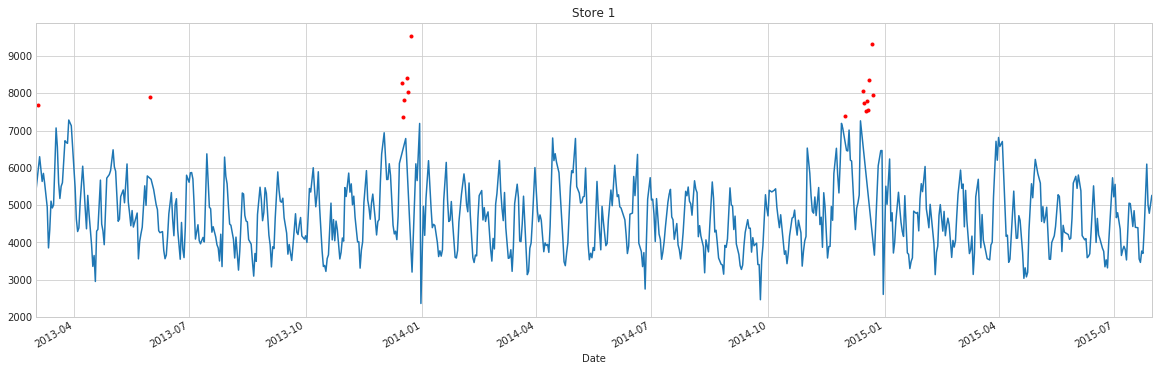

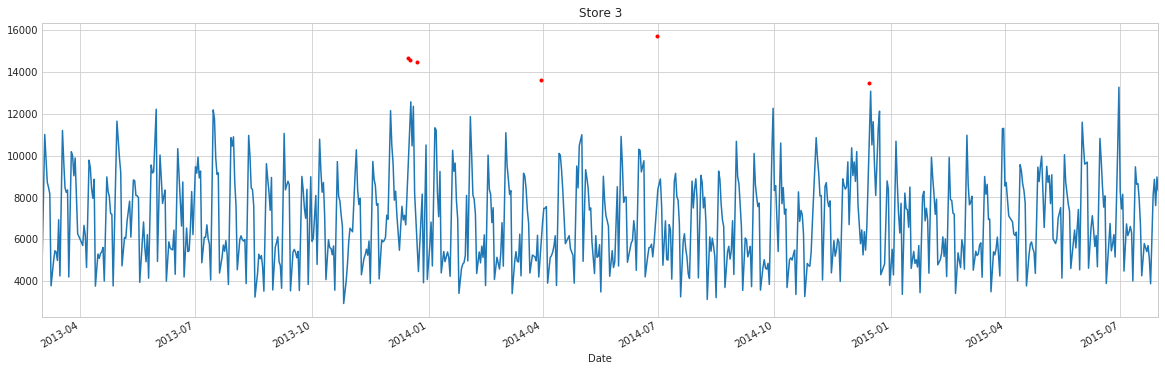

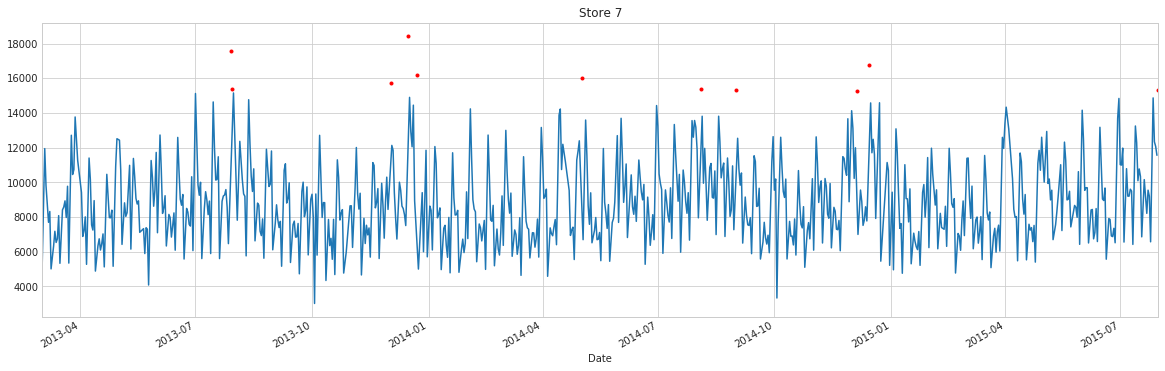

In [25]:
for index,group in all_df2.groupby('Store'):
    #print(index)
    group.set_index('Date',inplace=True,drop=False,verify_integrity=False)
    fig,ax1=plt.subplots(figsize=(20,6))
    group[(group['Set']==1)&(group['Outlier']==0)]['Sales'].plot()
    group[(group['Set']==1)&(group['Outlier']==1)]['Sales'].plot(style='r.')
    tmp_title = 'Store '+str(index)
    ax1.set_title(tmp_title)
    if index > 3:
        break

-----
### 观察新增衍生变量情况
* 历史销量的均值可以在一定程度上表示给定店铺的日销量销量趋势；
* 学校假期的时间段内，目测对销量影响不大；

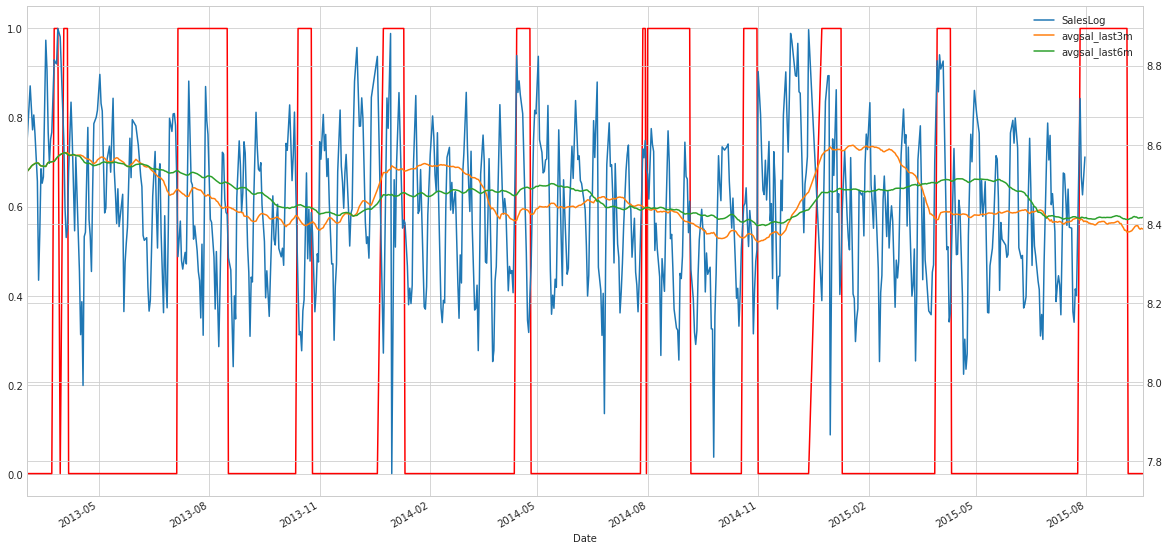

In [26]:
for index,group in all_df2[all_df2['Outlier']==0].groupby('Store'):
    group.set_index('Date',inplace=True,drop=False,verify_integrity=False)
    #print(group)
    
    fig,ax1=plt.subplots(figsize=(20,10))

    group['StateHoliday_tmp'] = group['SchoolHoliday'].apply(lambda x:0 if x==0 else 1)
    group['StateHoliday_tmp'].plot(ax=ax1,color='r')

    ax2 = ax1.twinx()
    group[['SalesLog','avgsal_last3m','avgsal_last6m']].plot(ax=ax2)
    break
    #group = group.sort_values('Date').set_indrop
    #print(group[group['StateHoliday']>0]['Date'].tolist())

### 保存数据集供模型训练

In [27]:
all_df2.to_csv('model_data0317_ext.csv', index=False)

In [28]:
all_df2[(all_df2['SalesLog']>0) & (all_df2['avgsal_last3m']>0)][['SalesLog','avgsal_last3m','avgsal_last6m']].describe()

,SalesLog,avgsal_last3m,avgsal_last6m
count,598143.000000,598143.000000,598143.000000
mean,8.757974,8.782907,8.777126
std,0.403329,0.313228,0.312293
min,5.659482,7.288039,7.288039
25%,8.494743,8.570845,8.566551
50%,8.755107,8.779455,8.774448
75%,9.018332,8.978474,8.970810
max,10.634701,10.169422,10.169422


-----
### 观察新增衍生变量与标签数据的互相关性

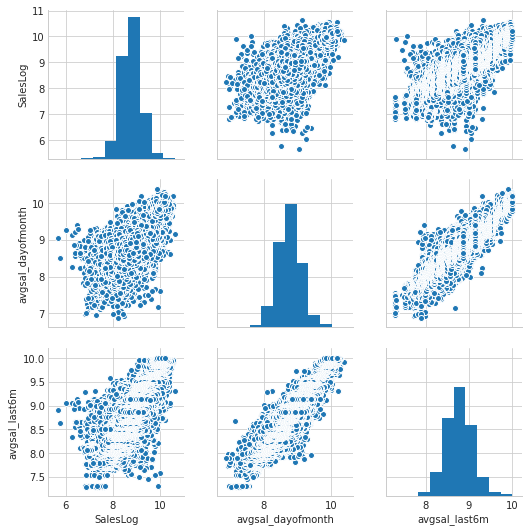

In [29]:
sns.pairplot(all_df2[(all_df2['SalesLog']>0) & (all_df2['avgsal_dayofmonth']>0)][['SalesLog','avgsal_dayofmonth','avgsal_last6m']])

In [30]:
all_df2.columns

Index(['Customers', 'Date', 'DayOfWeek', 'Id', 'Open', 'Promo', 'Sales',
       'SalesLog', 'SchoolHoliday', 'Set', 'StateHoliday', 'Store', 'Year',
       'MonthofYear', 'WeekofYear', 'DayofMonth', 'DayofYear', 'DateInt',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'Promo2SinceFloat', 'CompetitionOpenInt', 'sal_avg',
       'sal_avg_percustomer', 'sal_avg_promo', 'sal_avg_schoolhol',
       'sal_avg_statehol', 'sal_avg_std', 'CompetitionLastMonths',
       'inCompetition', 'Promo2LastMonths', 'Promo2_Month', 'inPromo2',
       'PromoIntervalType', 'avgsal', 'avgsal_curryear', 'avgsal_dayofmonth',
       'avgsal_dayofmonth_res', 'avgsal_dayofweek', 'avgsal_dayofweek_res',
       'avgsal_dayofyear', 'avgsal_last3m', 'avgsal_last6m', 'avgsal_mblm',
       'avgsal_percustomer', 'avgsal_std', 'daysFromLastSchHol',
       'daysFromLastSt